# 2020_dl_anomaly_detector

This is an experiment with deep learning for anomaly detection.

In [3]:
import torch

### Data Generators

Regular data (label=0) will be random data with mean=0, std=1. Define functions that can transform random data into irregular data (label=1) with spikes and steps.

In [65]:
import math

def spikes(data):
    
    print(data.shape)
    
    for i, _ in enumerate(data):
        len_data = len(data[i])-1
        step_point = 126 #int(math.fabs(torch.randn(1)[0])*len_data)
        if step_point > len_data:
            step_point = len_data
        print("Data Index:", i, "   Step Index:", step_point, "   Step Value:", data[i][step_point])
        for j, _ in enumerate(data[i][step_point:]):
            if i == 0:
                print(j)
            data[i][j] = data[i][step_point]*(data[i][j]*10).abs()
    
    return data

def step(data):
    
    for i, _ in enumerate(data):
        last_ind = len(data[i])-1
        step_point = int(math.fabs(torch.randn(1)[0])*last_ind*2/3)
        if step_point > last_ind:
            step_point = last_ind
        print("Data Index:", i, "   Step Index:", step_point, "   Step Value:", data[i][step_point])
        for j, _ in enumerate(data[i], start=step_point):
            # enumerate will wrap around to the beginning and continue
            # until the array is entirely enumerated and j = last_ind
            # We only want to go from the step point to the end 
            if j > last_ind:
                break
            data[i][j] = data[i][step_point]*5+data[i][j]
            
    return data
        

### Define the Data with Labels

In [99]:
from torch.utils.data.sampler import SubsetRandomSampler
import numpy as np

# Make the data half label 0 and half label 1 (step or other irregularization functions applied)
# Training data
train_data_0 = torch.randn(64, 256)
train_data_1 = step(torch.randn(64, 256))
train_data = torch.cat((train_data_0, train_data_1), dim=0)

# Validation data
valid_data = torch.randn(32, 256)

# Testing data
test_data_0 = torch.randn(16, 256)
test_data_1 = step(torch.randn(16, 256))
print(test_data_0.shape)
test_data = torch.cat((test_data_0, test_data_1), dim=0)
print(test_data.shape)

# Random samplers to mix 50/50 data
train_indices = np.random.shuffle(list(range(len(train_data))))
test_indices = list(range(len(test_data)))
np.random.shuffle(test_indices)
print(test_indices)
train_sampler = SubsetRandomSampler(train_indices)
test_sampler = SubsetRandomSampler(test_indices)

#train_labels = torch.zeros([4, 32], dtype=torch.long)
test_labels = torch.cat((torch.zeros(16, 256), torch.ones(16, 256)), dim=0)

train_loader = torch.utils.data.DataLoader(train_data, batch_size=32)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=32)

Data Index: 0    Step Index: 46    Step Value: tensor(-0.1324)
Data Index: 1    Step Index: 181    Step Value: tensor(1.8948)
Data Index: 2    Step Index: 98    Step Value: tensor(1.0335)
Data Index: 3    Step Index: 132    Step Value: tensor(0.1577)
Data Index: 4    Step Index: 157    Step Value: tensor(0.4190)
Data Index: 5    Step Index: 150    Step Value: tensor(0.7081)
Data Index: 6    Step Index: 255    Step Value: tensor(-0.2663)
Data Index: 7    Step Index: 116    Step Value: tensor(-0.8413)
Data Index: 8    Step Index: 31    Step Value: tensor(-0.2785)
Data Index: 9    Step Index: 65    Step Value: tensor(-1.0874)
Data Index: 10    Step Index: 80    Step Value: tensor(1.2132)
Data Index: 11    Step Index: 255    Step Value: tensor(-1.5080)
Data Index: 12    Step Index: 2    Step Value: tensor(-0.6259)
Data Index: 13    Step Index: 207    Step Value: tensor(-1.2951)
Data Index: 14    Step Index: 26    Step Value: tensor(0.5331)
Data Index: 15    Step Index: 35    Step Value: te

### Visualize the Data

torch.Size([32, 256])


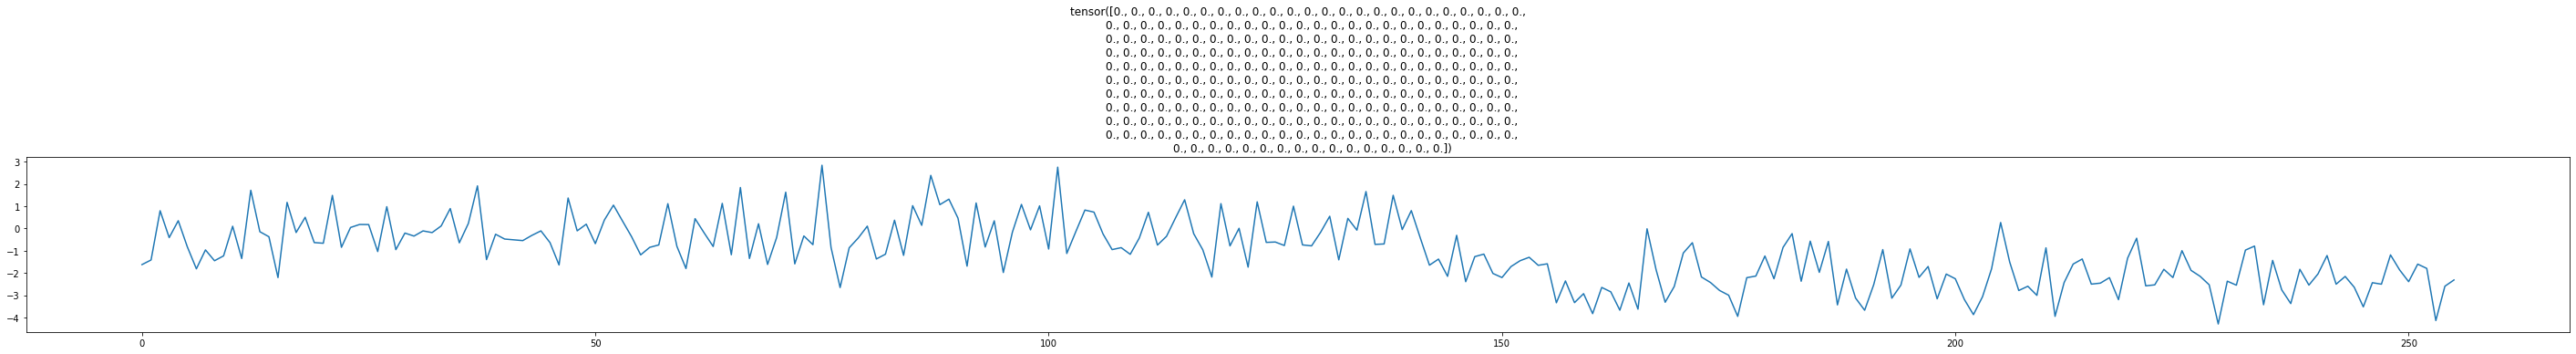

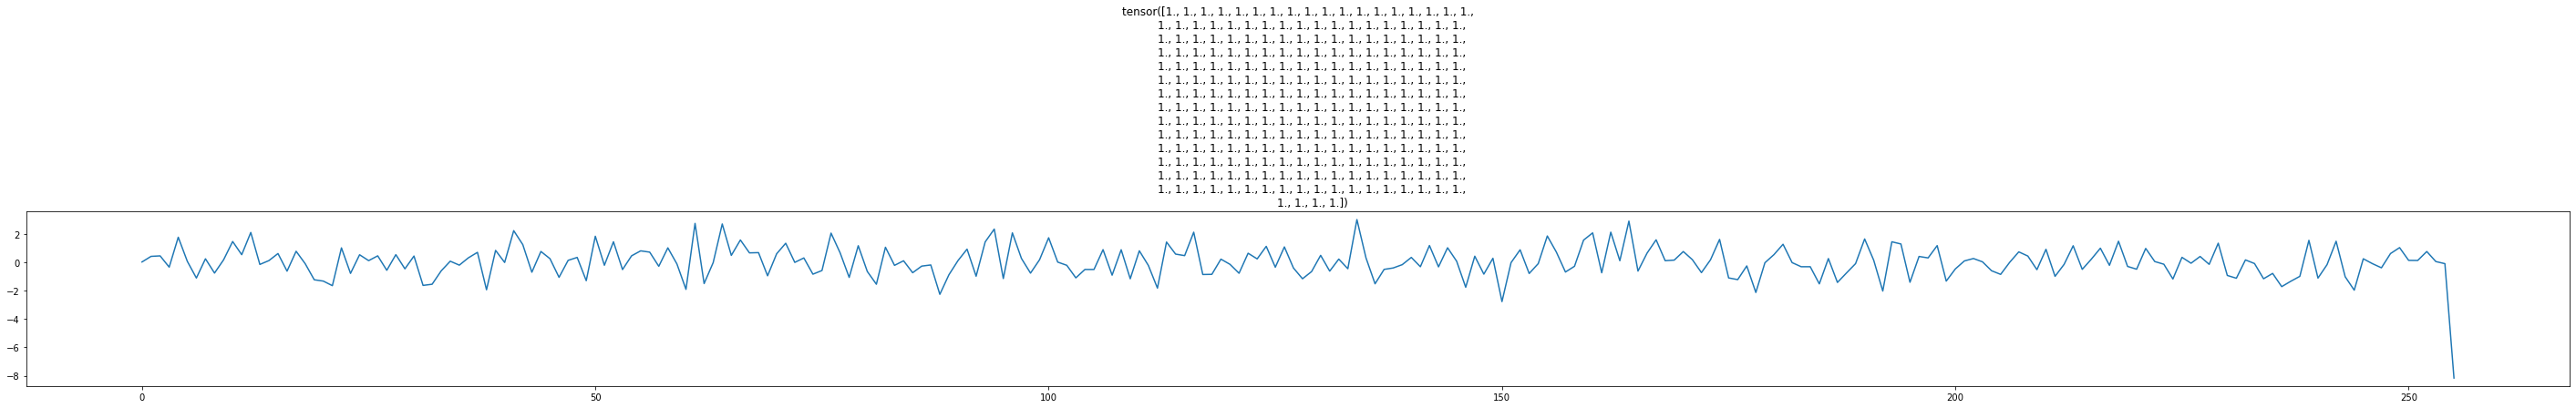

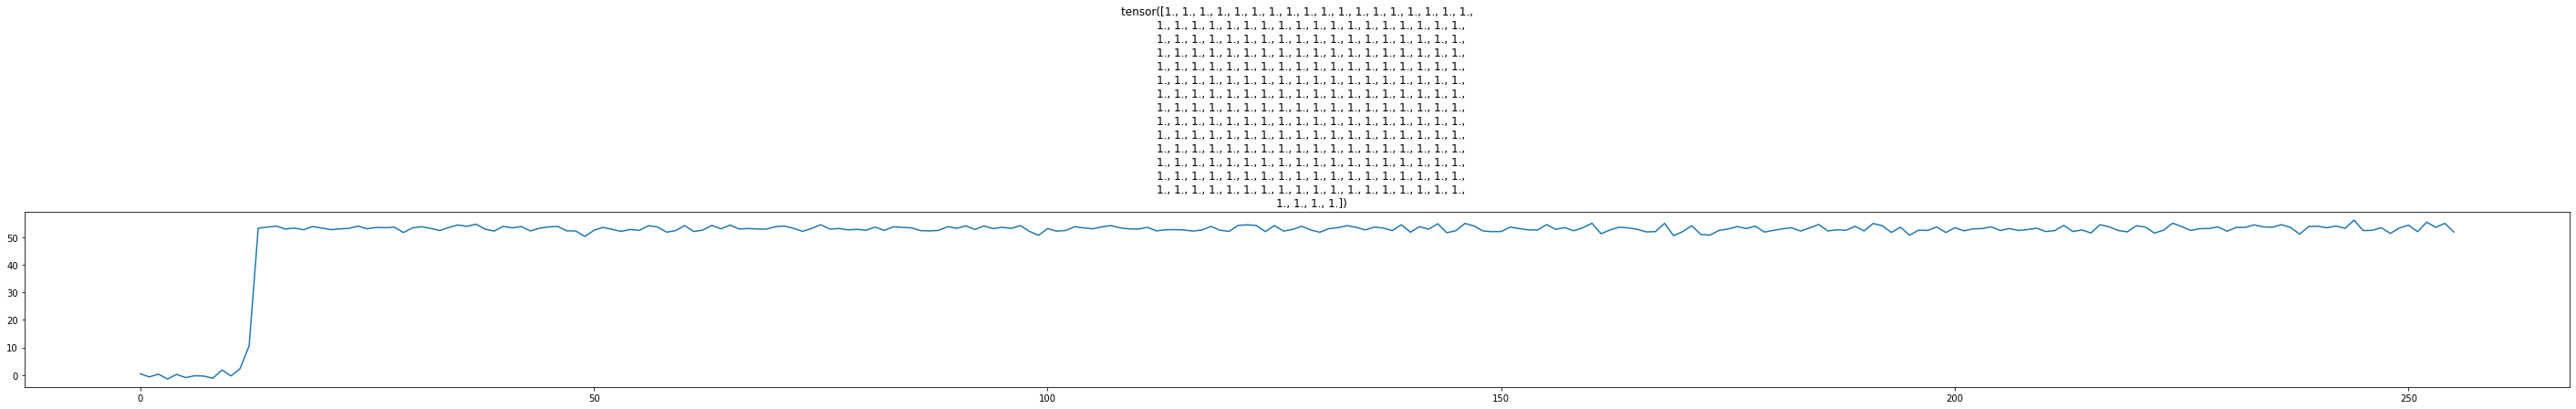

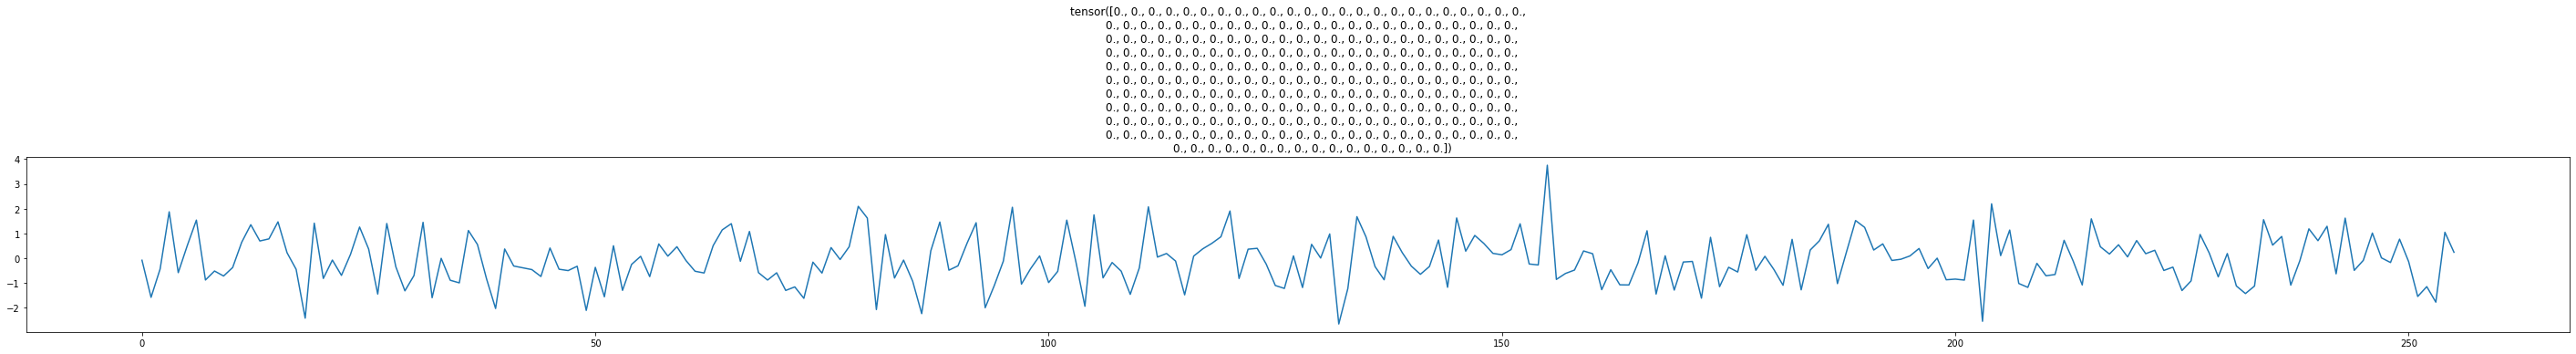

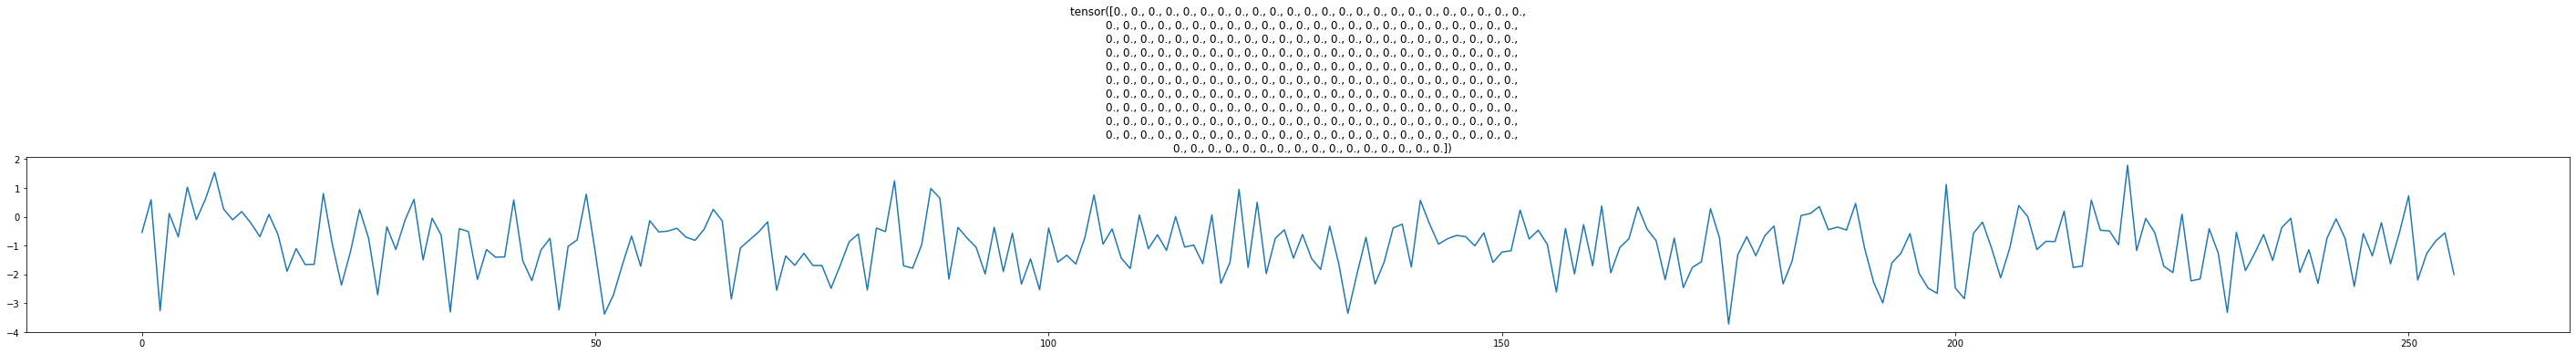

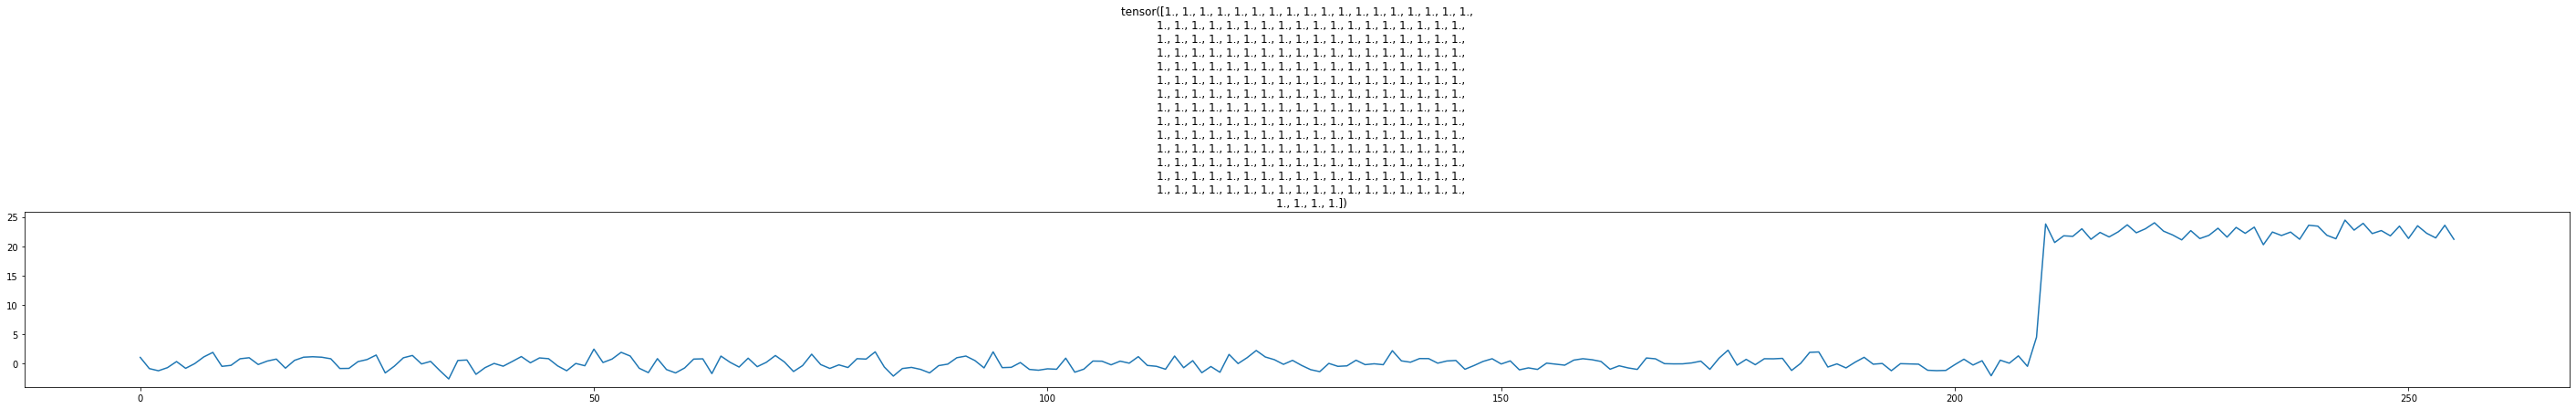

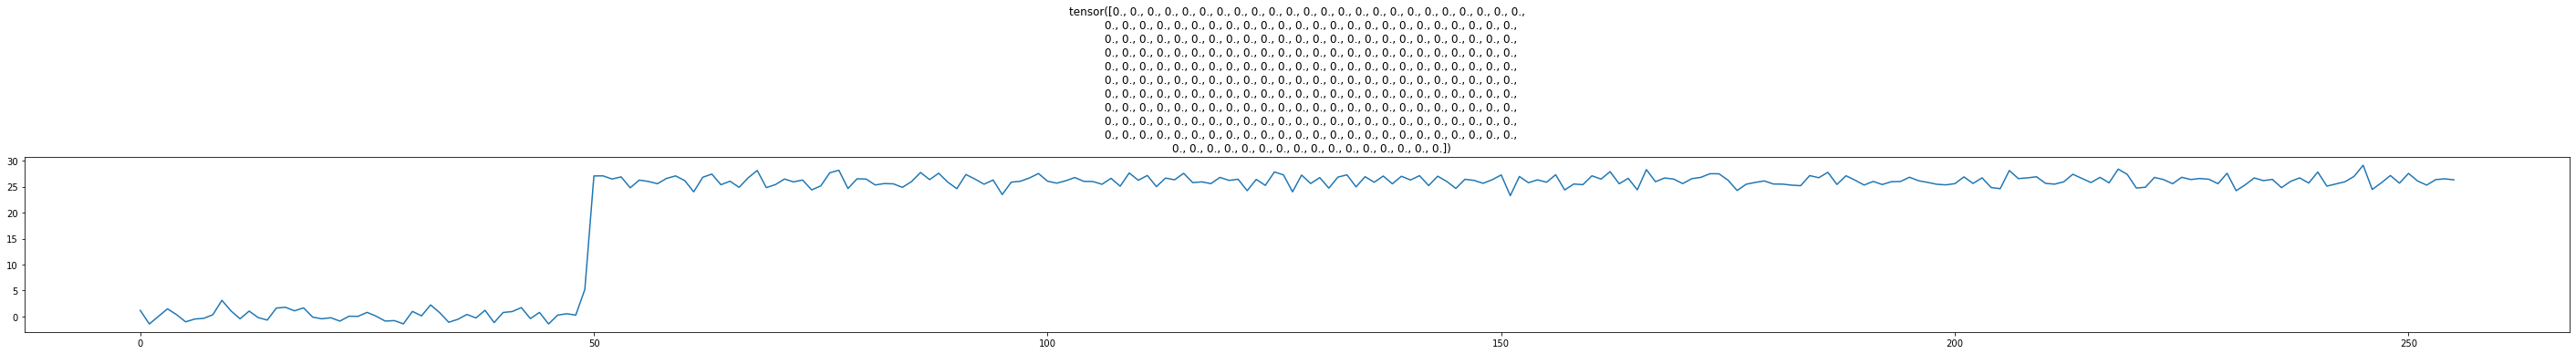

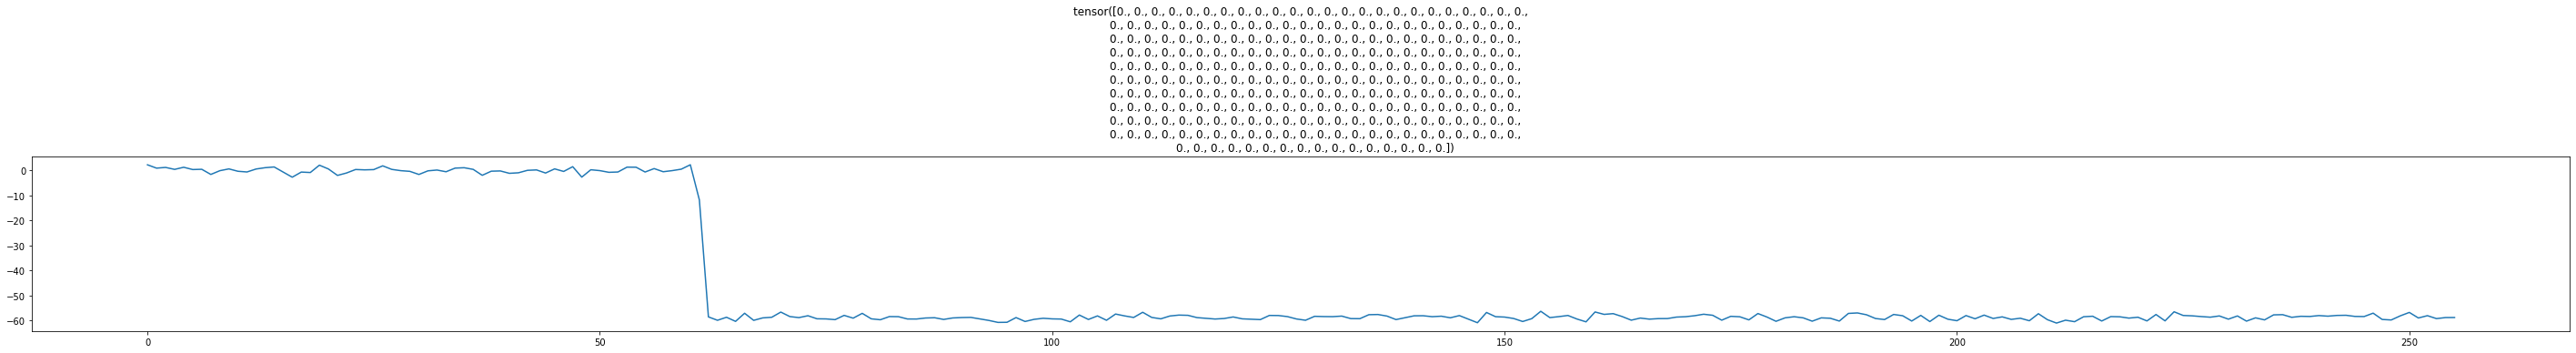

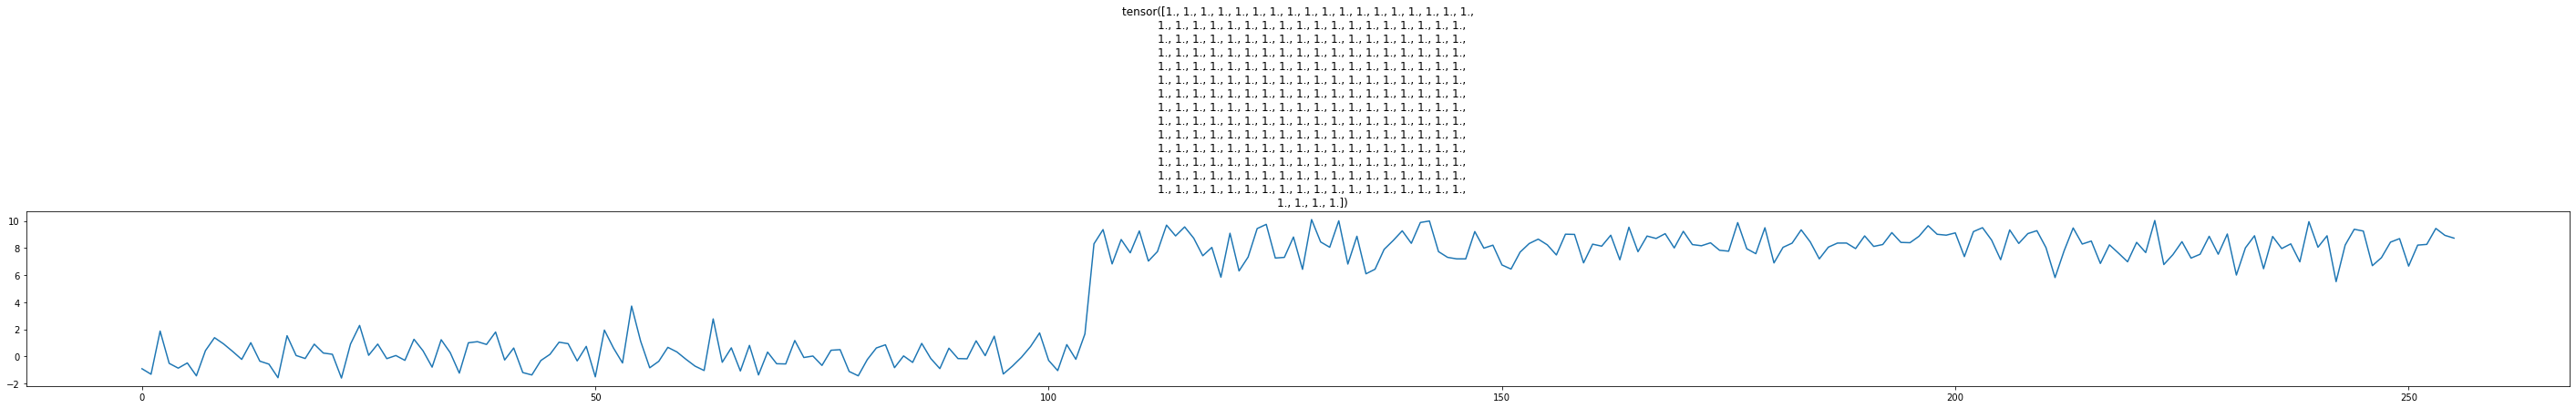

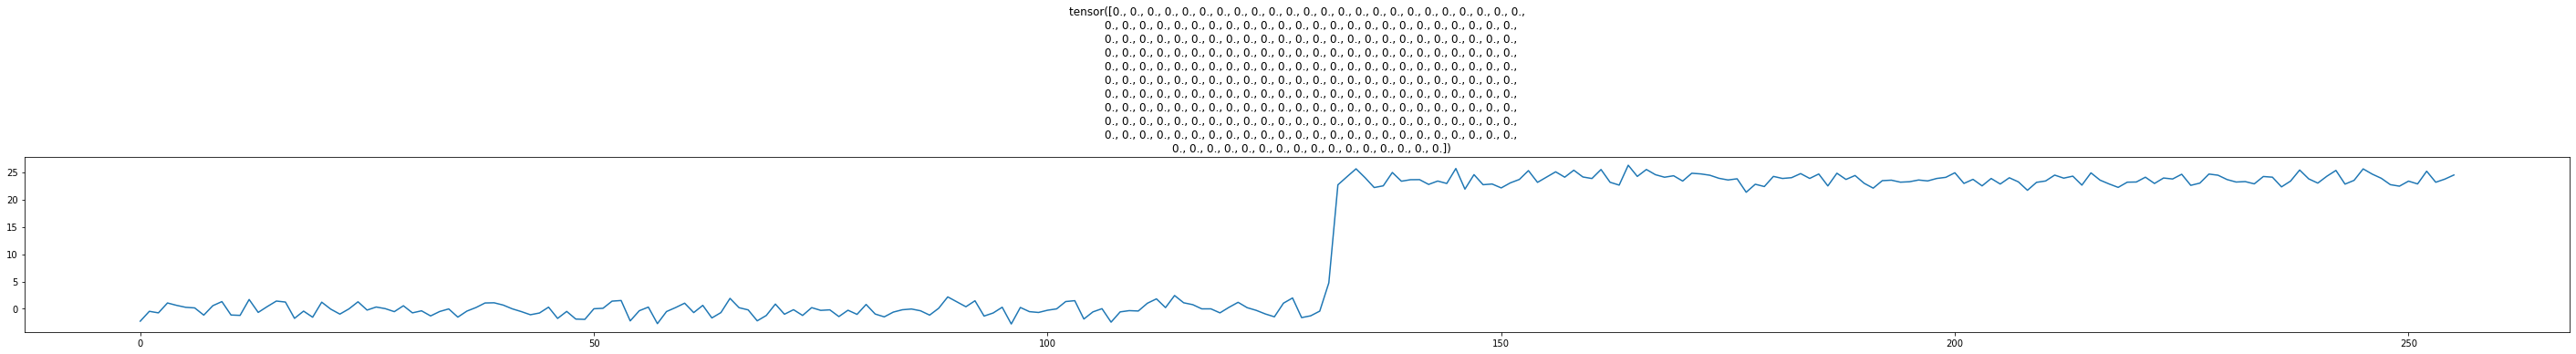

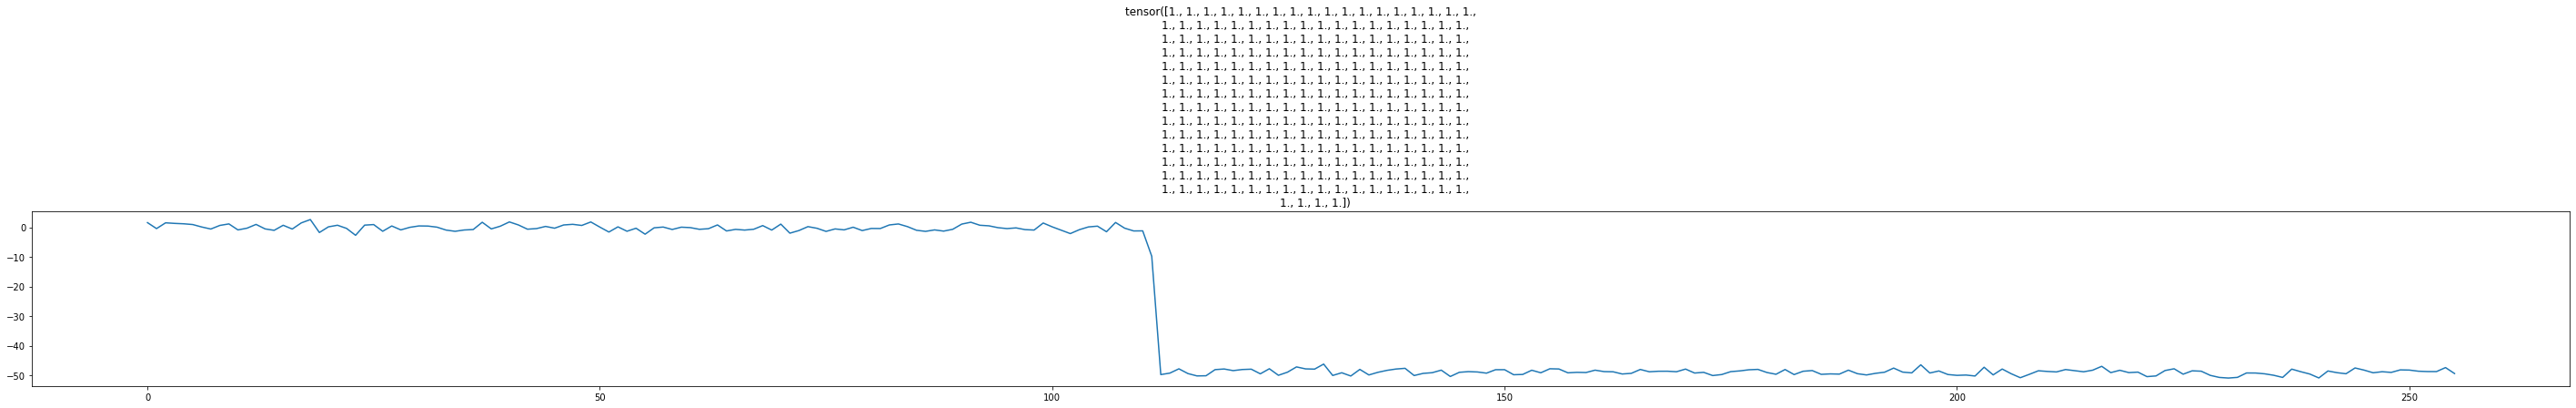

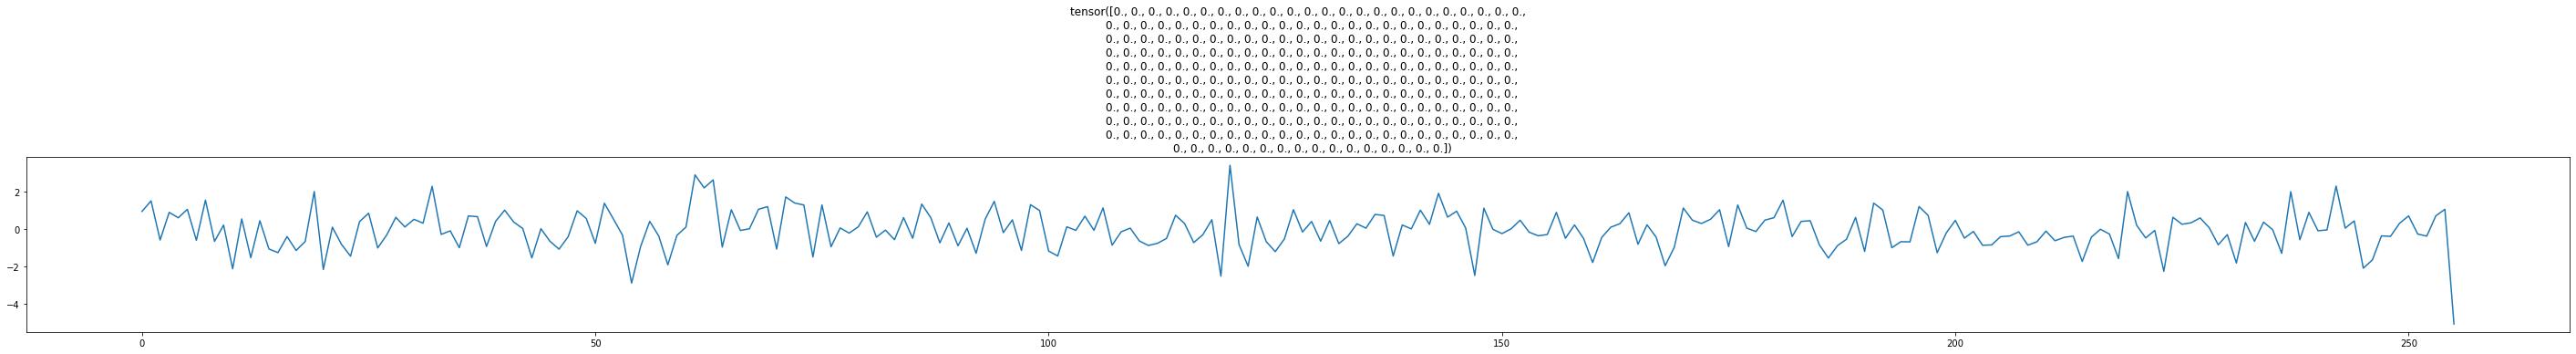

In [100]:
import matplotlib.pyplot as plt

dataiter = iter(test_loader)
data = dataiter.next()
print(data.shape)

for i, dset in enumerate(data[20:]):
    plt.figure(figsize=(50, 50))
    plt.subplot(12, 1, i+1)
    plt.plot(dset)
    plt.title(test_labels[test_indices[i]])

### Define the Model

In [63]:
from torch import nn
import torch.nn.functional as F

class Model(nn.Module):
    def __init__(self):
        super(Model, self).__init__()
        
        self.fc1 = nn.Linear(256, 64)
        self.fc2 = nn.Linear(64, 2)
        
    def forward(self, x):
        x = F.relu(self.fc1(x))
        
        return F.softmax(self.fc2(x), dim=1)
    
model = Model()
model

Model(
  (fc1): Linear(in_features=256, out_features=64, bias=True)
  (fc2): Linear(in_features=64, out_features=2, bias=True)
)

In [64]:
error_funct = nn.NLLLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.003)

### Train the Model

In [58]:
epochs = 30

for e in range(epochs):
    
    label_iter = iter(train_labels)
    
    train_loss = 0
    train_losses = []
    
    for data in train_loader:
        probs = model(data)
        
        optimizer.zero_grad()
        
        labels = next(label_iter)
        
        #print(data.shape, labels.shape, train_labels.shape, len(train_labels))
        
        loss = error_funct(probs, labels)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()*data.size(0)
        
    train_loss = train_loss/len(train_loader.sampler)
    train_losses.append(train_loss)
    
    print("Epoch:", e+1, "\tTraining loss:", train_loss) #, "\tValidation loss:", valid_loss)
        
        
    #for valid_data in valid_loader

Epoch: 1 	Training loss: -0.5819992870092392
Epoch: 2 	Training loss: -0.5887722074985504
Epoch: 3 	Training loss: -0.5954810678958893
Epoch: 4 	Training loss: -0.6021234542131424
Epoch: 5 	Training loss: -0.6086952686309814
Epoch: 6 	Training loss: -0.615193098783493
Epoch: 7 	Training loss: -0.6216136515140533
Epoch: 8 	Training loss: -0.6279538571834564
Epoch: 9 	Training loss: -0.634211465716362
Epoch: 10 	Training loss: -0.6403845101594925
Epoch: 11 	Training loss: -0.6464720219373703
Epoch: 12 	Training loss: -0.6524728536605835
Epoch: 13 	Training loss: -0.6583845764398575
Epoch: 14 	Training loss: -0.6642059981822968
Epoch: 15 	Training loss: -0.6699351221323013
Epoch: 16 	Training loss: -0.6755705326795578
Epoch: 17 	Training loss: -0.6811118125915527
Epoch: 18 	Training loss: -0.6865586489439011
Epoch: 19 	Training loss: -0.6919105350971222
Epoch: 20 	Training loss: -0.6971674114465714
Epoch: 21 	Training loss: -0.7023313045501709
Epoch: 22 	Training loss: -0.7074000686407089